### Load Features

In [11]:
# load dataset
import pandas as pd
ham_users_input = pd.read_csv('data/ham_features.csv')
spam_users_input = pd.read_csv('data/spam_features.csv')

### Data Preparation

In [12]:
# add labels
ham_users_input['label'] = 0 
spam_users_input['label'] = 1

In [13]:
# combine dataframes
df = pd.concat([ham_users_input,spam_users_input])
# drop userID
df.drop(['UserID'], axis=1, inplace=True)

In [14]:
# separate features from labels
X = df.drop('label', axis = 1)
y = df['label']

In [15]:
# split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training Classifier

### Evaluating Classifer

### Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV
import datetime

param_grid = { 
    'max_depth': [None, 5, 10, 25, 50, 100],
    'n_estimators': [50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.2, 0.5, 1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

print(f"START TIME: {datetime.datetime.now()}")
print("Beginning Grid Search for Hyperparameter Tuning.")
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1) 
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(f"Success!\nEND TIME: {datetime.datetime.now()}")

START TIME: 2023-11-28 09:26:18.350157
Beginning Grid Search for Hyperparameter Tuning.
Fitting 5 folds for each of 2430 candidates, totalling 12150 fits
RandomForestClassifier(max_depth=25, max_features='sqrt', max_samples=0.5,
                       n_estimators=200)
Success!
END TIME: 2023-11-28 18:33:25.729952


### Training Final Model after Tuning

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# train RF
clf = RandomForestClassifier(random_state= 26, max_depth = 25, max_features = 'sqrt', max_samples = 0.5, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, max_features='sqrt', max_samples=0.5,
                       n_estimators=200, random_state=26)

In [39]:
# predict on test set
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.5f}')

Accuracy: 0.95843
F1-Score: 0.96161


In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

Text(24.0, 0.5, 'True')

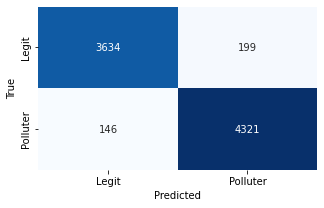

In [41]:
import seaborn as sn
import matplotlib.pyplot as plt
classes = ["Legit","Polluter"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')